# Non-metric Multidimensional Scaling

Today we will get a better feel for how Shepard's **Non-metric Multidimensional Scaling (NMDS)** algorithm works.

**We will be working in groups of two.**

Feel free to ask any questions and please show me your work before you leave.

In [1]:
# Run this cell before beginning the exercise.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tools import *

First, we will load a reference mental representation, this time with four animals and two dimensions. Our goal will be to recover these 2D points using only human similarity data. We don't usually have the "true" mental representation for comparison, but it's useful to have one in this exercise to prove to ourselves that NMDS actually works.

In [2]:
df_real_points = load_mental_representation()
df_real_points

,size,fur_length
dog,0.8,0.6
cat,0.3,0.7
wolf,1.0,0.8
rabbit,0.2,0.4


We can plot all four points to see how they are related in 2D space:

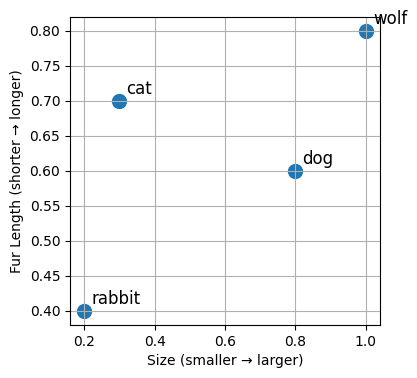

In [3]:
plt.figure(figsize=(4, 4))
plt.scatter(df_real_points['size'], df_real_points['fur_length'], s=100)
for i, animal in enumerate(df_real_points.index):
    plt.annotate(animal, (df_real_points.iloc[i, 0], df_real_points.iloc[i, 1]), 
                 fontsize=12, xytext=(5, 5), textcoords='offset points')
plt.xlabel('Size (smaller → larger)')
plt.ylabel('Fur Length (shorter → longer)')
plt.grid(True)
plt.show()

We want to recover these points using only what we can observe from people: similarity ratings. The similarity data for the same set of animals is loaded below.

In [4]:
df_sim = load_sim_data()
df_sim

,dog,cat,wolf,rabbit
dog,1.000000,0.600554,0.753638,0.531286
cat,0.600554,1.000000,0.493069,0.728893
wolf,0.753638,0.493069,1.000000,0.408842
rabbit,0.531286,0.728893,0.408842,1.000000


The functions you created last time are already loaded and accessible: `get_pairwise_distances`, and `flatten_lower_triangle`.

**Exercise 1**: Using the functions mentioned above, compute distances between points in `df_real_points` and store them in a dataframe called `df_real_distances`. Then store the unique distances in an array called `real_distances`. Next, store the unique similarity values in an array called `similarities`.

In [5]:
# Your solution here
df_real_distances = get_pairwise_distances(df_real_points).astype('float')
real_distances = flatten_lower_triangle(df_real_distances)
similarities = np.exp(-real_distances)

# don't change the below
try:
    print("Real Distances:", '\n', df_real_distances, '\n')
    print("Unique Distances:", '\n', real_distances, '\n')
    print("Unique Similarities:", '\n', similarities, '\n')
except:
    print("Code not working yet.")

Real Distances: 
              dog       cat      wolf    rabbit
dog     0.000000  0.509902  0.282843  0.632456
cat     0.509902  0.000000  0.707107  0.316228
wolf    0.282843  0.707107  0.000000  0.894427
rabbit  0.632456  0.316228  0.894427  0.000000 

Unique Distances: 
 [0.50990195 0.28284271 0.70710678 0.63245553 0.31622777 0.89442719] 

Unique Similarities: 
 [0.60055446 0.75363832 0.49306869 0.53128561 0.72889341 0.40884172] 



In [6]:
# TEST YOUR SOLUTION

# DON'T CHANGE THIS CELL
test1 = np.isclose(df_real_distances.at['cat', 'dog'], 0.509902, atol=1e-5)
test2 = np.isclose(real_distances[-1], 0.89442719, atol=1e-5)
test3 = np.isclose(similarities[-1],0.40884172, atol=1e-5)
if test1 and test2 and test3:
    print('Test passed')
else:
    print('Test failed')

Test passed


**Exercise 2**: Use a scatter plot to verify the relationship between similarity and distance in psychological space. Also plot the curve for Shepard's Law for comparison. Fill in the blanks below. Make sure that the data follow what you'd expect from Shepard's law.

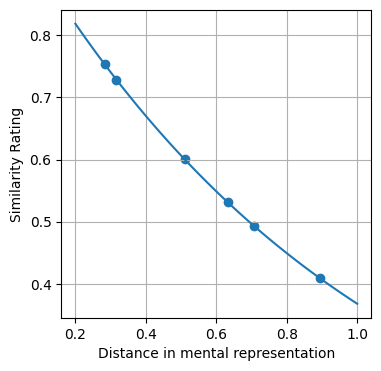

In [7]:
fig1 = plt.figure(figsize=(4, 4))

# relationship between similarity and distance
plt.scatter(real_distances,similarities)

# Shepard's Law
dist = np.linspace(0.2, 1, 100)
y = np.exp(-dist)
plt.plot(dist, y)
plt.xlabel('Distance in mental representation')
plt.ylabel('Similarity Rating')
plt.grid()
plt.show()

In [8]:
# TEST YOUR SOLUTION

# DON'T CHANGE THIS CELL
if np.isclose(y[0], 0.81873075, atol=1e-5):
    print('Test passed')
else:
    print('Test failed')

Test passed


Now let's assume we don't have the points in `df_real_points` and try to recover them from the similarity data.

NMDS begins by randomly placing a point representing each object into a space (in our case a 2D space) and then iteratively adjusts them based on criteria we will review below.

**Exercise 3**: Create a function called `create_initial_random_points` that outputs a dataframe with the same index names as `df_real_points` but with random points and columns: `["dim1", "dim2"]`. Values on each dimension should be between 0 and 1 (this is for simplicity and not strictly required for NMDS). You can generate uniform random values using `np.random.rand()`.

In [9]:
# Your code here
def create_initial_random_points():
    df = pd.DataFrame(
        index=['dog','cat','wolf','rabbit'], 
        columns=['dim1','dim2']
    )
    
    for ind in df.index:
        for col in df.columns:
            df.loc[ind,col] = np.random.rand()
    
    return df



# don't change the below
try:
    np.random.seed(0)
    print(create_initial_random_points())
except:
    print("Code not working yet.")

            dim1      dim2
dog     0.548814  0.715189
cat     0.602763  0.544883
wolf    0.423655  0.645894
rabbit  0.437587  0.891773


In [10]:
# TEST YOUR SOLUTION

# DON'T CHANGE THIS CELL
np.random.seed(0)
_ = create_initial_random_points().loc['dog', 'dim1']
if np.isclose(_, float("8423729305318845.0"[::-1]), atol=1e-5):
    print('Test passed')
else:
    print('Test failed')

Test passed


In order to assess randomly generated sets of points and begin improving them, we need a way to measure the extent to which a particular configuration of points is a good one.

All we really need is a measure that captures the difference between:
1. the distance between two points (i.e., animals) in psychological space, and
2. the distance between our current guesses for those two points.

In order words, we want our point distances to exactly match the "real" (psychological) distances.

Given our current guess for the points, such as the random ones above, we can calculate $\hat{d}_{ij}$: the distance the points for object $i$ (e.g., animal $i$) and object $j$. That's item 2 above.

**Exercise 4**: Use our existing set of functions to:
- Create a set of random points for the animals in a dataframe called `df_guesses`.
- Compute distances between points in `df_guesses` and store them in a dataframe called `df_guessed_dist`.
- Store the unique distances in an array called `guessed_distances`.

You shouldn't have to write any new code.

In [11]:
# do not change
np.random.seed(14)

# Your code goes here
df_guesses = create_initial_random_points()
df_guessed_dist = get_pairwise_distances(df_guesses)
guessed_distances = flatten_lower_triangle(df_guessed_dist)


# don't change the below
try:
    print("Initial Point Guesses:", '\n', df_guesses, '\n')
    print("Distances between above:", '\n', df_guessed_dist, '\n')
    print("Unique Distances:", '\n', guessed_distances, '\n')
except:
    print("Code not working yet.")

Initial Point Guesses: 
             dim1      dim2
dog     0.513943  0.773165
cat     0.870428  0.008047
wolf    0.309736  0.957604
rabbit  0.513117  0.318284 

Distances between above: 
              dog       cat      wolf    rabbit
dog          0.0  0.844089   0.27517  0.454881
cat     0.844089       0.0  1.102739    0.4732
wolf     0.27517  1.102739       0.0   0.67089
rabbit  0.454881    0.4732   0.67089       0.0 

Unique Distances: 
 [0.84408933 0.27516958 1.10273902 0.45488138 0.47320019 0.67088966] 



In [12]:
# TEST YOUR SOLUTION

# DON'T CHANGE THIS CELL
test1 = np.isclose(df_guesses.at['dog', 'dim1'], 0.513943, atol=1e-5)
test2 = np.isclose(df_guessed_dist.at['dog', 'cat'], 0.844089, atol=1e-5)
test3 = np.isclose(guessed_distances[0], 0.844089, atol=1e-5)
if test1 and test2 and test3:
    print('Test passed')
else:
    print('Test failed')

Test passed


Recall that what we want is a measure that captures the difference between:
1. the distance between two points (i.e., animals) in psychological space, and
2. the distance between our current guesses for those two points.

We now have item 2.

To obtain the item 1 (psychological distances), remember that Shepard's Law tells us that similarity $s = e^{-d}$ and inversely that psychological distance $d = -log(s)$.

If we say that the similarity between object $i$ and object $j$ is $s_{ij}$, then psychological distance $d_{ij} = -log(s_{ij})$. (Make sure not to confuse $\hat{d}_{ij}$ and $d_{ij}$.)

**Exercise 5**: Create a function called `sim_to_dist` that takes in an array of similarity values and returns an array of psychological distances.

In [13]:
# Your code here

def sim_to_dist(similarities):
    return -np.log(similarities)

# don't change the below
try:
    print('Psychological Distances:', sim_to_dist(similarities))
except:
    print("Code not working yet.")

Psychological Distances: [0.50990195 0.28284271 0.70710678 0.63245553 0.31622777 0.89442719]


In [14]:
# TEST YOUR SOLUTION

# DON'T CHANGE THIS CELL
if np.isclose(sim_to_dist(similarities)[1], 0.28284271, atol=1e-5):
    print('Test passed')
else:
    print('Test failed')

Test passed



Thus, the difference we are interested in is just $-log(s_{ij}) - \hat{d}_{ij}$.

NMDS uses a very similar measure, called **stress**:

$Stress = \sqrt{\sum_{i<j} \left( -log(s_{ij}) - \hat{d}_{ij} \right)^2}$

Because the sign of the difference doesn't matter, the stress measure squares this difference to make it positive. It also sums up these squared differences for all pairs of objects $i$ and $j$. Note that $i<j$ just means that we work with unique similarities/distances rather than double counting $(i, j)$ and $(j, i)$. We then take the square root of the sum to get us back on the scale of distances rather than squared distances.

**Exercise 6**: Create a function called `stress` that takes in a one-dimensional array of unique similarity values and a one-dimensional array of unique point distances and returns the measure of stress discussed above as a float. You can reuse your `sim_to_dist` function above.

In [15]:
# Your answer here
def stress(similarities, unique_distances):
    return np.sqrt(
            np.sum(
                np.pow(
                    sim_to_dist(similarities)-unique_distances, 2
                    )
                )
            ).astype("float")


# don't change the below
try:
    print('Stress:', stress(similarities, guessed_distances))
except:
    print("Code not working yet.")

Stress: 0.6118879829822872


In [16]:
# TEST YOUR SOLUTION

# DON'T CHANGE THIS CELL
if np.isclose(stress(similarities, guessed_distances), 0.6118879829822872, atol=1e-5):
    print('Test passed')
else:
    print('Test failed')

Test passed


Shepard didn't always know the relationship between similarity and distance. In that case, stress is expressed more generally as:

$Stress = \sqrt{\sum_{i<j} \left( f(s_{ij}) - \hat{d}_{ij} \right)^2}$

where $f$ is an arbitrary monotonic function.

If we didn't yet know that $f(s) = -log(s)$, that is, the inverse of $e^{-d}$, holds for psychological similarity, then we'd have to infer it on our own from the data. Shepard did this as an additional step in the NMDS algorithm which looks for the function $f$ that best fits the data.

Since, we already know the form of this function, we'll skip that step for simplicity, but it's important to note that this is how Shepard discoverd his universal law.

**Exercise 7**: Apply your stress function to distances for the randomly guessed points and store the result in a float called `stress_for_guessed`.

In [17]:
# Your code here
stress_for_guessed = stress(np.exp(-guessed_distances),guessed_distances)

try:
    print('Stress for guessed points:', stress_for_guessed)
except:
    print("Code not working yet.")

Stress for guessed points: 5.551115123125783e-17


In [18]:
# TEST YOUR SOLUTION

# DON'T CHANGE THIS CELL
if np.isclose(stress_for_guessed, 0.6118879829822872, atol=1e-5):
    print('Test passed')
else:
    print('Test failed')

Test failed


**Exercise 8**: Apply your stress function to the real psychological distances and store the result in a float called `stress_for_real`.

In [19]:
# Your code here

stress_for_real = stress(similarities, real_distances)

try:
    print(f"Stress for real points: {stress_for_real:.2f}")
except:
    print("Code not working yet.")

Stress for real points: 0.00


In [20]:
# TEST YOUR SOLUTION

# DON'T CHANGE THIS CELL
if np.isclose(stress_for_real, 0, atol=1e-5):
    print('Test passed')
else:
    print('Test failed')

Test passed


Let's see our current guesses for the points and try to determine how they could be improved. Observe the plots below. Ignore the code.

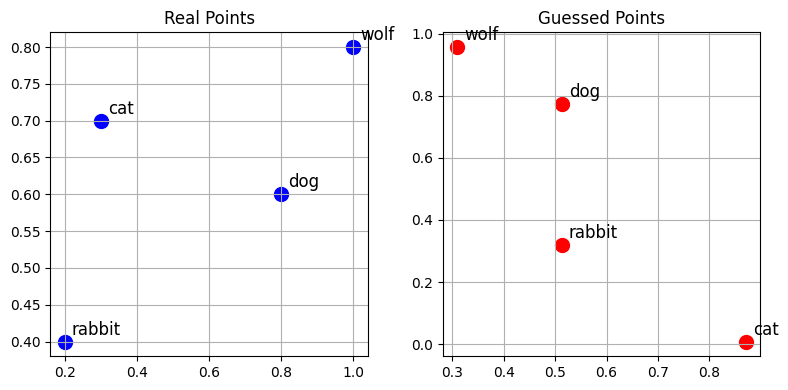

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# real points
ax1.scatter(df_real_points['size'], df_real_points['fur_length'], s=100, color='blue')
for i, label in enumerate(df_real_points.index):
    ax1.annotate(label, (df_real_points.iloc[i, 0], df_real_points.iloc[i, 1]),
                fontsize=12, xytext=(5, 5), textcoords='offset points')
ax1.set_title('Real Points')
ax1.grid(True)

# guess points
ax2.scatter(df_guesses['dim1'], df_guesses['dim2'], s=100, color='red')
for i, label in enumerate(df_guesses.index):
    ax2.annotate(label, (df_guesses.iloc[i, 0], df_guesses.iloc[i, 1]),
                fontsize=12, xytext=(5, 5), textcoords='offset points')
ax2.set_title('Guessed Points')
ax2.grid(True)

plt.tight_layout()
plt.show()

**Exercise 9**: Select the two biggest issues with the guessed points from the below options.

Remember, we are only comparing the **distances** between points in the two plots, not the exact locations of the points themselves.

In [22]:
# answer1 = "dog too close to wolf; dog too close to cat"
# answer1 = "dog too close to rabbit; dog too far from cat"
# answer1 = "dog too close to cat; dog too far from rabbit"

In [23]:
# TEST YOUR SOLUTION

# DON'T CHANGE THIS CELL
if ';ti'[::-1] in answer1:
    print('Test passed')
else:
    print('Test failed')

NameError: name 'answer1' is not defined

The biggest issue seems to be that dog is too far from cat relative to the other points. Now imagine drawing a line from dog to cat. To move the dog point towards the cat, we would take a step along that line. We'd take the largest step in that direction than in any other since that's the largest discrepency.

The second biggest issue seems to be that dog is too close to rabbit relative to other points. Instead of moving the dog point down towards rabbit, we'd move it straight up away from it. We'd take a smaller step than the above since it's not as big of a discrepency.

NMDS calculates these directions for each point. You'll learn how to do this in more detail in a later assignment.

For the dog point, the directions can be visualized with the code below. We want to take a big step toward cat and a small step away from rabbit. After we take those steps, the stress value will be reduced.

In [ ]:
_, directions = get_gradient_for_one_point(df_guesses, df_sim, df_guessed_dist, 'dog')
# points
plt.figure(figsize=(4, 4))
plt.scatter(df_guesses['dim1'], df_guesses['dim2'])
for animal in df_guesses.index:
    dist, y = df_guesses.loc[animal]
    plt.text(dist, y, animal)
# arrows
dog_x, dog_y = df_guesses.loc['dog']
for animal in directions.index:
    if animal == 'dog':
        continue
    dist, y = directions.loc[animal] * -0.5
    plt.arrow(dog_x, dog_y, dist, y, head_width=0.01, head_length=0.01, fc='r', ec='r')
plt.show()

NMDS performs these point movements iteratively. On each iteration, it computes these directions for each point (e.g., three directions for each of the four animals) and uses them to make small steps in each direction. It then re-evaluates stress and begins again, calculating directions and taking another step.

**Exercise 10**:

Below we're going to perform NMDS using a function called `update_points`. 

Note that we already created random initial points and called them `df_guesses_new`.

You can call `update_points(df_guesses_new, df_sim)` to move each point in a direction that will reduce stress and return the new resulting points as a similar dataframe.

Create a loop below to update the points 100 times. Store the resulting stress values for each iteration in an array called `stress_vals`. Also print them out one by one in your loop so you can see if it's being reduced over time.

In [ ]:
# do not change
np.random.seed(10)
df_guesses_new = create_initial_random_points()
# do not change

# Your code here



In [ ]:
# TEST YOUR SOLUTION

# DON'T CHANGE THIS CELL
if len(stress_vals)==100 and np.isclose(stress_vals[-1], 0., atol=1e-5) and np.isclose(stress_vals[10], 0.05693107008290327, atol=1e-5):
    print('Test passed')
else:
    print('Test failed')

Run the below cell to visualize how stress decreases across the 100 iterations.

In [ ]:
plt.plot(stress_vals)
plt.xlabel('Iteration')
plt.ylabel('Stress')
plt.show()

**Question 11:** Based on the above, by what earliest iteration has a stable configuration of points been found?

In [ ]:
# answer2 = 20
# answer2 = 40
# answer2 = 60
# answer2 = 80
# answer2 = 100

In [ ]:
# TEST YOUR SOLUTION

# DON'T CHANGE THIS CELL
if answer2 % 16 == 0:
    print('Test passed')
else:
    print('Test failed')

We can now compare the original points from the psychological representation to those found by the NDMS algorithm:

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# real points
ax1.scatter(df_real_points['size'], df_real_points['fur_length'], s=100, color='blue')
for i, label in enumerate(df_real_points.index):
    ax1.annotate(label, (df_real_points.iloc[i, 0], df_real_points.iloc[i, 1]),
                fontsize=12, xytext=(5, 5), textcoords='offset points')
ax1.set_title('Psychological Representation')
ax1.grid(True)

# guess points
ax2.scatter(df_guesses_new['dim1'], df_guesses_new['dim2'], s=100, color='red')
for i, label in enumerate(df_guesses_new.index):
    ax2.annotate(label, (df_guesses_new.iloc[i, 0], df_guesses_new.iloc[i, 1]),
                fontsize=12, xytext=(5, 5), textcoords='offset points')
ax2.set_title('NMDS: Inferred Psychological Representation')
ax2.grid(True)

plt.tight_layout()
plt.show()

NMDS can successfully recover points that have the same distances as the points in the psychological space (those indicated only by human similarity judgments).

However, the specific (x, y) dimensions of the found points will amost always not have the same meaning as those for the original points. In the original representations, the first dimension represented size and the second represented fur length. The NMDS space will almost certaintly not have those same dimensions. Because simililarity ratings only tell us about distance, and not about exact location in space, NMDS can only infer the overal configuration of the points (in this case, a rough diamond shape). In particular, NMDS will correctly return the above diamond configuration, but one that is arbitrarily rotated in space. Thus, it's up to the researcher to further rotate the configuration and interpret the meaning of the dimensions.